# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

- UPDATE: I'm using the AVE split now

In [11]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
# from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


SEED=5
SEED=1000

#TODO: rename to result_p 
data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

lit_pcba_full_data_p = Path(f"/p/vast1/jones289/lit_pcba/lit_pcba_full_data")

In [16]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [12]:
# model_dict = {
#     "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
#     "hdbind-rp-molformer": ("HDBind+MolFormer-10k", green_color_pal[6]),
#     "hdbind-rp-molformer-100k": ("HDBind+MolFormer-100k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1": ("HDBind+ECFP-10k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-100k": ("HDBind+ECFP-100k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-1m": ("HDBind+ECFP-1m", green_color_pal[6]),    
#     "mlp-1024-1": ("MLP", blue_color_pal[7]),
#     "Vina": ("Vina", "salmon"),
# }
# model_dict = {
    # "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
    # "hdbind-rp-ecfp-1024-1": ("HDB-ECFP", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-100k": ("HDB-ECFP-100k", green_color_pal[6]),
    # "hdbind-rp-molclr":  ("HDB-MolCLR", green_color_pal[6]),
#     "hdbind-rp-molclr-100k":  ("HDB-MolCLR-100k", green_color_pal[6]),
    # "hdbind-rp-molformer": ("HDB-MolFormer", green_color_pal[6]),
#     "hdbind-rp-molformer-100k": ("HDB-MolFormer-100k", green_color_pal[6]),
    # "hdbind-rp-molformer-ecfp-combo": ("HDB-MolFormer+ECFP", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-1m": ("HDBind+ECFP-1m", green_color_pal[6]),    
    # "mlp-1024-1": ("MLP", blue_color_pal[7]),
    # "Vina": ("Vina", "salmon"),
# }
model_dict = {
    "hdbind-directecfp-1k-1": ("HDB-DECFP-1k-1", green_color_pal[4]),
    "hdbind-directecfp-1k-2": ("HDB-DECFP-1k-2", green_color_pal[4]),
    "hdbind-directecfp-1k-4": ("HDB-DECFP-1k-4", green_color_pal[4]),
    "hdbind-directecfp-10k-1": ("HDB-DECFP-10k-1", green_color_pal[6]),
    "hdbind-directecfp-10k-2": ("HDB-DECFP-10k-2", green_color_pal[6]),
    "hdbind-directecfp-10k-4": ("HDB-DECFP-10k-4", green_color_pal[6]),
    "hdbind-directecfp-100k-1": ("HDB-DECFP-100k-1", green_color_pal[8]),
    "hdbind-directecfp-100k-2": ("HDB-DECFP-100k-2", green_color_pal[8]),
    "hdbind-directecfp-100k-4": ("HDB-DECFP-100k-4", green_color_pal[8]),
    "Vina": ("Vina", "salmon"),
}

# LIT-PCBA Results

export CONDA_ROOT=/usr/workspace/jones289/anaconda3-power #installed using the LC installer script
export PATH=$CONDA_ROOT/bin:$PATH
export CONDA_EXE=$CONDA_ROOT/bin/conda
ml load gcc/11
export PYTHONPATH=$PWD:$PYTHONPATH
source activate /usr/workspace/jones289/anaconda3-power/envs/opence-1.8.0

In [13]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


def compute_metrics(y_pred, y_score, y_true, p):
#     import pdb
#     pdb.set_trace()


    if y_score.squeeze().ndim == 2:
        enrich = float(compute_enrichment_factor(scores=y_score[:, 1], labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score[:, 1], y_true=y_true)
    else:
        enrich = float(compute_enrichment_factor(scores=y_score, labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score, y_true=y_true)

    
    
    return {"precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
           "f1": f1_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "enrich": enrich,            
           "roc": roc
           }


def aggregate_results(dataset, split, target_list=None):
    assert target_list is not None
#     import pdb
#     pdb.set_trace() 
    
#     if split == "random":
#         raise NotImplementedError # rename the files with "-random" to be consistent
        
    
    model_metric_dict = {"model": [], "enrich": [], "p":[], "train_time":[], "test_time": [], "target": [],
                        "seed": [], "recall": [], "precision": [], "f1": [], 
#                          "smiles": []
                        }


    for model_name, model_tup in tqdm(model_dict.items(), total=len(model_dict), position=0):
                        

        data_path_list = list(data_p.glob(f"{model_name}.{dataset}-*-{split}*.pkl"))
#         print(f"{model_name}\t{dataset}\t{len(model_tup)}\t {len(data_path_list)}")

        
        for path in tqdm(data_path_list, total=len(data_path_list), position=1):
            target = path.name.split(".")[1].split("-")[-2]
            print(target, path, model_name)

            if target in target_list or target_list == "all":
                pass
            else:
                continue
            
            model_data_dict = torch.load(path)
            
            # apparently we have duplicates in the test set...
            

            for seed in range(len(model_data_dict['trials'])):

    
                
                trial_dict = model_data_dict['trials'][seed]
            
            

                for p in [.01, .1]:

                    try:

                        
                        y_pred = trial_dict["y_pred"]
                        y_score = trial_dict["eta"]
                        
                        if model_name == "mlp":
                            y_score = y_score[:, 1]
                        
                        
#                         y_true = model_data_dict["y_test"]
                        y_true = trial_dict["y_true"]


                        # TODO: there are some issues with the number of smiles not lining up with the number of predictions/etc...
#                         import pdb
#                         pdb.set_trace()
                        print(f"y_pred: {y_pred.shape}\ty_score: {y_score.shape}\ty_true: {y_true.shape}")

                        
                        
                        metrics = compute_metrics(y_pred=y_pred, 
                                                  y_score=y_score, 
                                                  y_true=y_true,
                                                 p=p)

                        
                        
                        
                        
                        
                        
                        model_metric_dict["target"].append(target)
                        model_metric_dict["test_time"].append(trial_dict["test_time"])
                        model_metric_dict["enrich"].append(metrics["enrich"])
                        model_metric_dict["p"].append(p)
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
                        model_metric_dict["model"].append(model_name)
#                         model_metric_dict["smiles"].append(model_data_dict["smiles_test"])
                        
                    except Exception as e:
                        print(e)


    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})

#     import pdb
#     pdb.set_trace()
    return model_metric_df
        


# VINA result

In [ ]:
from pathlib import Path

'''
def load_lit_pcba_vina(nrows=None, split=None, target_list=None):

    
#     assert target_list is not None
    assert split is not None



    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")
    lig_map_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/lig_rec/")
#     /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/lig_rec/ # this path stores the map between conveyor and the original files
    
    path_list = [path for path in root_p.glob("*-actives.csv")]
#     print(len(path_list))

    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        
#         import pdb
#         pdb.set_trace()
        target = path.name.split(".")[0].split("-")[0]
#         print(target, target_list, (target in target_list))
        if target in target_list or target_list == "all":

        
            active_lig_map = pd.read_csv(lig_map_p / f"lig-{target}-actives.csv")
            inactive_lig_map = pd.read_csv(lig_map_p / f"lig-{target}-inactives.csv")

            lig_map = pd.concat([active_lig_map, inactive_lig_map])

            
#             import pdb
#             pdb.set_trace()
            active_smiles_df = pd.read_csv(f"{lit_pcba_full_data_p}/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"{lit_pcba_full_data_p}/{target}/inactives.smi", delim_whitespace=True, header=None)
            smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])

            input_num_mols = smiles_df.shape[0]


            # Filter out the test set smiles strings

            test_smiles_path = f"/p/vast1/jones289/hd_results/{SEED}/hdbind-rp-molformer.lit-pcba-{target}-{split}.{SEED}.pkl"         
            print(test_smiles_path)
            test_smiles = torch.load(test_smiles_path)["smiles_test"]

#             import pdb
#             pdb.set_trace()

            # TODO: there's missing docking data?
            smiles_df = pd.merge(smiles_df, pd.DataFrame({0: test_smiles}), on=0)

            smiles_df = smiles_df.drop_duplicates(subset=[0])

            print(f"started with {input_num_mols} molecules for {target}, after merging with available docking data, have {smiles_df.shape[0]}/{len(test_smiles)} in test set")



    #         smiles_df = smiles_df[smiles_df[1].apply(lambda x: x in test_smiles.values)]





            target_df = pd.merge(lig_map, smiles_df, left_on=" name", right_on=1)

            # dock_score_cols = {idx: value for idx,value in enumerate(["file", "key", "Mesg", "Box/cx", "Box/cy", "Box/cz", "Box/dx", "Box/dy", "Box/dz", 
                        #    "ligName", 
                        #    "numPose", 
                        #    "scores/1", 
                        #    "scores/2", 
                        #    "scores/3", 
                        #    "scores/4", 
                        #    "scores/5", 
                        #    "scores/6", 
                        #    "scores/7", 
                        #    "scores/8", 
                        #    "scores/9", 
                        #    "scores/10", 
                        #    "Box/default"])}
            lig_id_col = 9
            active_dock_scores = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), header=None)
            active_dock_scores["label"] = [1] * len(active_dock_scores)

            inactive_dock_scores = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), header=None)
            inactive_dock_scores["label"] = [0] * len(inactive_dock_scores)
            dock_scores = pd.concat([active_dock_scores, inactive_dock_scores])


            dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)


            dock_scores = dock_scores.groupby(lig_id_col)[[lig_id_col, 'min_vina', 'label']].min().reset_index(drop=True)


            target_df = pd.merge(dock_scores, target_df, left_on=9, right_on=" name")

            target_df["target"] = [target] * len(target_df)

            # compute enrichment at 1% and 10%




    #         import pdb
    #         pdb.set_trace() 

            df_list.append(target_df)
        else:
            pass


    df = pd.concat(df_list)
    return df
'''

'\ndef load_lit_pcba_vina(nrows=None, split=None, target_list=None):\n\n    \n#     assert target_list is not None\n    assert split is not None\n\n\n\n    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")\n    lig_map_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/lig_rec/")\n#     /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/lig_rec/ # this path stores the map between conveyor and the original files\n    \n    path_list = [path for path in root_p.glob("*-actives.csv")]\n#     print(len(path_list))\n\n    df_list = []\n\n    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):\n        \n#         import pdb\n#         pdb.set_trace()\n        target = path.name.split(".")[0].split("-")[0]\n#         print(target, target_list, (target in target_list))\n        if target in target_list or target_list == "all":\n\n        \n            active_lig_map = pd.read_csv(lig_map_p / f"lig-{target}-actives.csv")\n            inactive_lig_map = pd.read_csv(lig_map_p / f

In [14]:
def process_target(target_name="VDR", target_id="AID504847"):



    train_actives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_active_T.smi", header=None, delim_whitespace=True) 
    test_actives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_active_V.smi", header=None, delim_whitespace=True) 
    test_actives["label"] = [1] * len(test_actives)
    train_actives["label"] = [1] * len(train_actives)

    train_inactives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_inactive_T.smi", header=None, delim_whitespace=True) 
    test_inactives = pd.read_csv(f"/p/vast1/jones289/lit_pcba/AVE_unbiased/{target_name}/{target_id}_inactive_V.smi", header=None, delim_whitespace=True) 
    test_inactives["label"] = [0] * len(test_inactives)
    train_inactives["label"] = [0] * len(train_inactives)



    print("train_actives.shape", train_actives.shape, 
        "train_inactives.shape", train_inactives.shape,
        "test_actives.shape", test_actives.shape,
        "test_inactives.shape", test_inactives.shape)

    dock_actives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-actives.csv")
    dock_actives["id"] = dock_actives[" key"].apply(lambda x: int(x.split("/")[-1]))
    dock_inactives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-inactives.csv")
    dock_inactives["id"] = dock_inactives[" key"].apply(lambda x: int(x.split("/")[-1]))


    print("dock_actives.shape", dock_actives.shape, "dock_inactives.shape",dock_inactives.shape)



    train_df = pd.concat([train_actives, train_inactives])
    train_df["id"] = train_df[1]
    test_df = pd.concat([test_actives, test_inactives])
    test_df["id"] = test_df[1]

    print("train_df.shape", train_df.shape, "test_df.shape", test_df.shape)

    dock_actives["dock_id"] = dock_actives[' key'].apply(lambda x: int(x.split("/")[-1]))
    dock_inactives["dock_id"] = dock_inactives[' key'].apply(lambda x: int(x.split("/")[-1]))


    print("dock_actives.shape", dock_actives.shape, "dock_inactives.shape", dock_inactives.shape)


    active_lig_map_df = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/lig_rec/lig-{target_name}-actives.csv")
    active_lig_map_df["id"] = active_lig_map_df[" key"].apply(lambda x: int(x.split("/")[-1]))


    inactive_lig_map_df = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/lig_rec/lig-{target_name}-inactives.csv")
    inactive_lig_map_df["id"] = inactive_lig_map_df[" key"].apply(lambda x: int(x.split("/")[-1]))

    print("active_lig_map_df.shape", active_lig_map_df.shape, "inactive_lig_map_df.shape", inactive_lig_map_df.shape)

    active_df = pd.merge(dock_actives, active_lig_map_df, left_on="dock_id", right_on="id")
    inactive_df = pd.merge(dock_inactives, inactive_lig_map_df, left_on="dock_id", right_on="id")

    print("active_df.shape", active_df.shape, "inactive_df.shape", inactive_df.shape)

    train_active_df = pd.merge(active_df, train_df, left_on=" name", right_on="id")
    test_active_df = pd.merge(active_df, test_df, left_on=" name", right_on="id")
    train_inactive_df = pd.merge(inactive_df, train_df, left_on=" name", right_on="id")
    test_inactive_df = pd.merge(inactive_df, test_df, left_on=" name", right_on="id")

    print("train_active_df.shape", train_active_df.shape, "train_inactive_df.shape", train_inactive_df.shape)
    print("test_active_df.shape", test_active_df.shape, "test_inactive_df.shape", test_inactive_df.shape)


    train_df = pd.concat([train_active_df, train_inactive_df])
    test_df = pd.concat([test_active_df, test_inactive_df])

    print("train_data size ", train_df.shape, train_df["id"].unique().shape)
    print("test_data size", test_df.shape, test_df["id"].unique().shape)


    # print(train_df.head())
    # print(test_df.head())


    # import pdb 
    # pdb.set_trace()
    test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)
    test_df["target"] = [target_name] * len(test_df)


    return test_df

def load_lit_pcba_vina():
    
    target_tup_list = [

        ("492947", "ADRB2"),
        ("1030", "ALDH1"),
        ("743075", "ESR1_ago"),
        ("743080", "ESR1_ant"),
        ("588795", "FEN1"),
        ("2101", "GBA"),
        ("602179", "IDH1"),
        ("504327", "KAT2A"),
        ("995", "MAPK1"),
        ("493208", "MTORC1"),
        ("1777", "OPRK1"),
        ("1631", "PKM2"),
        ("743094", "PPARG"),
        ("651631", "TP53"),
        ("504847", "VDR"),




    ]


    # target_tup_list = [target_tup_list[0]]


    df_list = []
    for target_id, target_name in target_tup_list:
        print(target_id, target_name) 
        target_df = process_target(target_name, target_id=f"AID{target_id}")
        df_list.append(target_df)
        print()


    df = pd.concat(df_list)

    return df

In [15]:

def make_box_plot(enrich_1_df, enrich_10_df, dataset:str, split:str):
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    
    enrich_f.suptitle(f"{dataset.upper()} ({split})")
    
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", 
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_1_ax)
    enrich_1_ax.set_title(f"Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

        
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich",
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_10_ax)

    enrich_10_ax.set_title(f"Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [model_dict[item.get_text()][0] for item in enrich_10_ax.get_xticklabels()]

    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()

    enrich_f.savefig(f"{dataset}-{split}-enrich.png", dpi=600, bbox_inches="tight")





def compute_model_metric_df(dataset, split, target_list=None):
    
    assert target_list is not None
    
    # docking_df = load_lit_pcba_vina(target_list=target_list, split=split)
    docking_df = load_lit_pcba_vina() # need an argument to load the data for the random splits

    
    model_metric_df = aggregate_results(dataset=dataset,
                                        split=split, target_list=target_list)
    

    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_col='min_vina'
    label_col = "label"
    for target, target_df in docking_df.groupby("target"):

        for p in [.1, .01]:
            enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df[label_col], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)

    # takes the data extracted from the ml/hdbind methods and sticks the docking data on the bottom 
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    
    # take the average over the random seeds dimension for each combo of MODEL X TARGET X P
    grp_df = (model_metric_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()
    grp_df = grp_df.sort_values(by="model")
    
    
    for name, group in grp_df.groupby(["model", "p"]):
        print(name)
        print(group.describe())


    make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1],
             dataset=dataset, split=split)

    return model_metric_df


492947 ADRB2
train_actives.shape (13, 3) train_inactives.shape (234363, 3) test_actives.shape (4, 3) test_inactives.shape (78120, 3)
dock_actives.shape (128, 23) dock_inactives.shape (2499856, 23)
train_df.shape (234376, 4) test_df.shape (78124, 4)
dock_actives.shape (128, 24) dock_inactives.shape (2499856, 24)
active_lig_map_df.shape (16, 7) inactive_lig_map_df.shape (312482, 7)
active_df.shape (128, 31) inactive_df.shape (2499856, 31)
train_active_df.shape (96, 35) train_inactive_df.shape (1874896, 35)
test_active_df.shape (32, 35) test_inactive_df.shape (624960, 35)
train_data size  (1874992, 35) (234374,)
test_data size (624992, 35) (78124,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1030 ALDH1
train_actives.shape (4032, 3) train_inactives.shape (77606, 3) test_actives.shape (1344, 3) test_inactives.shape (25868, 3)
dock_actives.shape (57336, 23) dock_inactives.shape (1103712, 23)
train_df.shape (81638, 4) test_df.shape (27212, 4)
dock_actives.shape (57336, 24) dock_inactives.shape (1103712, 24)
active_lig_map_df.shape (7167, 7) inactive_lig_map_df.shape (137964, 7)
active_df.shape (57336, 31) inactive_df.shape (1103712, 31)
train_active_df.shape (32256, 35) train_inactive_df.shape (620840, 35)
test_active_df.shape (10744, 35) test_inactive_df.shape (206944, 35)
train_data size  (653096, 35) (81637,)
test_data size (217688, 35) (27211,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



743075 ESR1_ago
train_actives.shape (10, 3) train_inactives.shape (4188, 3) test_actives.shape (3, 3) test_inactives.shape (1395, 3)
dock_actives.shape (180, 23) dock_inactives.shape (83730, 23)
train_df.shape (4198, 4) test_df.shape (1398, 4)
dock_actives.shape (180, 24) dock_inactives.shape (83730, 24)
active_lig_map_df.shape (12, 7) inactive_lig_map_df.shape (5582, 7)
active_df.shape (180, 31) inactive_df.shape (83730, 31)
train_active_df.shape (135, 35) train_inactive_df.shape (62805, 35)
test_active_df.shape (45, 35) test_inactive_df.shape (20925, 35)
train_data size  (62940, 35) (4196,)
test_data size (20970, 35) (1398,)

743080 ESR1_ant
train_actives.shape (77, 3) train_inactives.shape (3711, 3) test_actives.shape (25, 3) test_inactives.shape (1237, 3)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


dock_actives.shape (1515, 23) dock_inactives.shape (74205, 23)
train_df.shape (3788, 4) test_df.shape (1262, 4)
dock_actives.shape (1515, 24) dock_inactives.shape (74205, 24)
active_lig_map_df.shape (101, 7) inactive_lig_map_df.shape (4947, 7)
active_df.shape (1515, 31) inactive_df.shape (74205, 31)
train_active_df.shape (1140, 35) train_inactive_df.shape (55665, 35)
test_active_df.shape (375, 35) test_inactive_df.shape (18540, 35)
train_data size  (56805, 35) (3787,)
test_data size (18915, 35) (1261,)

588795 FEN1


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (277, 3) train_inactives.shape (266552, 3) test_actives.shape (92, 3) test_inactives.shape (88850, 3)
dock_actives.shape (368, 23) dock_inactives.shape (355401, 23)
train_df.shape (266829, 4) test_df.shape (88942, 4)
dock_actives.shape (368, 24) dock_inactives.shape (355401, 24)
active_lig_map_df.shape (368, 7) inactive_lig_map_df.shape (355401, 7)
active_df.shape (368, 31) inactive_df.shape (355401, 31)
train_active_df.shape (276, 35) train_inactive_df.shape (266551, 35)
test_active_df.shape (92, 35) test_inactive_df.shape (88850, 35)
train_data size  (266827, 35) (266827,)
test_data size (88942, 35) (88942,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



2101 GBA
train_actives.shape (125, 3) train_inactives.shape (222039, 3) test_actives.shape (41, 3) test_inactives.shape (74013, 3)
dock_actives.shape (990, 23) dock_inactives.shape (1776306, 23)
train_df.shape (222164, 4) test_df.shape (74054, 4)
dock_actives.shape (990, 24) dock_inactives.shape (1776306, 24)
active_lig_map_df.shape (165, 7) inactive_lig_map_df.shape (296051, 7)
active_df.shape (990, 31) inactive_df.shape (1776306, 31)
train_active_df.shape (744, 35) train_inactive_df.shape (1332228, 35)
test_active_df.shape (246, 35) test_inactive_df.shape (444078, 35)
train_data size  (1332972, 35) (222162,)
test_data size (444324, 35) (74054,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



602179 IDH1
train_actives.shape (30, 3) train_inactives.shape (271537, 3) test_actives.shape (9, 3) test_inactives.shape (90512, 3)
dock_actives.shape (532, 23) dock_inactives.shape (5068672, 23)
train_df.shape (271567, 4) test_df.shape (90521, 4)
dock_actives.shape (532, 24) dock_inactives.shape (5068672, 24)
active_lig_map_df.shape (38, 7) inactive_lig_map_df.shape (362048, 7)
active_df.shape (532, 31) inactive_df.shape (5068672, 31)
train_active_df.shape (406, 35) train_inactive_df.shape (3801504, 35)
test_active_df.shape (126, 35) test_inactive_df.shape (1267168, 35)
train_data size  (3801910, 35) (271565,)
test_data size (1267294, 35) (90521,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



504327 KAT2A
train_actives.shape (146, 3) train_inactives.shape (261411, 3) test_actives.shape (48, 3) test_inactives.shape (87137, 3)
dock_actives.shape (579, 23) dock_inactives.shape (1045641, 23)
train_df.shape (261557, 4) test_df.shape (87185, 4)
dock_actives.shape (579, 24) dock_inactives.shape (1045641, 24)
active_lig_map_df.shape (193, 7) inactive_lig_map_df.shape (348547, 7)
active_df.shape (579, 31) inactive_df.shape (1045641, 31)
train_active_df.shape (435, 35) train_inactive_df.shape (784230, 35)
test_active_df.shape (144, 35) test_inactive_df.shape (261411, 35)
train_data size  (784665, 35) (261555,)
test_data size (261555, 35) (87185,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



995 MAPK1
train_actives.shape (231, 3) train_inactives.shape (46972, 3) test_actives.shape (77, 3) test_inactives.shape (15657, 3)
dock_actives.shape (4605, 23) dock_inactives.shape (939420, 23)
train_df.shape (47203, 4) test_df.shape (15734, 4)
dock_actives.shape (4605, 24) dock_inactives.shape (939420, 24)
active_lig_map_df.shape (307, 7) inactive_lig_map_df.shape (62628, 7)
active_df.shape (4605, 31) inactive_df.shape (939420, 31)
train_active_df.shape (3450, 35) train_inactive_df.shape (704565, 35)
test_active_df.shape (1155, 35) test_inactive_df.shape (234855, 35)
train_data size  (708015, 35) (47201,)
test_data size (236010, 35) (15734,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



493208 MTORC1
train_actives.shape (73, 3) train_inactives.shape (24729, 3) test_actives.shape (24, 3) test_inactives.shape (8243, 3)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:24: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  dock_inactives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-inactives.csv")


dock_actives.shape (1056, 23) dock_inactives.shape (362681, 23)
train_df.shape (24802, 4) test_df.shape (8267, 4)
dock_actives.shape (1056, 24) dock_inactives.shape (362681, 24)
active_lig_map_df.shape (96, 7) inactive_lig_map_df.shape (32971, 7)
active_df.shape (1056, 31) inactive_df.shape (362681, 31)
train_active_df.shape (803, 35) train_inactive_df.shape (272019, 35)
test_active_df.shape (253, 35) test_inactive_df.shape (90662, 35)
train_data size  (272822, 35) (24802,)
test_data size (90915, 35) (8265,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1777 OPRK1
train_actives.shape (18, 3) train_inactives.shape (202362, 3) test_actives.shape (6, 3) test_inactives.shape (67454, 3)
dock_actives.shape (23, 23) dock_inactives.shape (269815, 23)
train_df.shape (202380, 4) test_df.shape (67460, 4)
dock_actives.shape (23, 24) dock_inactives.shape (269815, 24)
active_lig_map_df.shape (23, 7) inactive_lig_map_df.shape (269815, 7)
active_df.shape (23, 31) inactive_df.shape (269815, 31)
train_active_df.shape (17, 35) train_inactive_df.shape (202361, 35)
test_active_df.shape (6, 35) test_inactive_df.shape (67454, 35)
train_data size  (202378, 35) (202378,)
test_data size (67460, 35) (67460,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1631 PKM2
train_actives.shape (410, 3) train_inactives.shape (184143, 3) test_actives.shape (136, 3) test_inactives.shape (61380, 3)
dock_actives.shape (4905, 23) dock_inactives.shape (2209698, 23)
train_df.shape (184553, 4) test_df.shape (61516, 4)
dock_actives.shape (4905, 24) dock_inactives.shape (2209698, 24)
active_lig_map_df.shape (545, 7) inactive_lig_map_df.shape (245522, 7)
active_df.shape (4905, 31) inactive_df.shape (2209698, 31)
train_active_df.shape (3681, 35) train_inactive_df.shape (1657278, 35)
test_active_df.shape (1224, 35) test_inactive_df.shape (552420, 35)
train_data size  (1660959, 35) (184551,)
test_data size (553644, 35) (61516,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



743094 PPARG
train_actives.shape (21, 3) train_inactives.shape (3909, 3) test_actives.shape (6, 3) test_inactives.shape (1302, 3)
dock_actives.shape (390, 23) dock_inactives.shape (78150, 23)
train_df.shape (3930, 4) test_df.shape (1308, 4)
dock_actives.shape (390, 24) dock_inactives.shape (78150, 24)
active_lig_map_df.shape (26, 7) inactive_lig_map_df.shape (5210, 7)
active_df.shape (390, 31) inactive_df.shape (78150, 31)
train_active_df.shape (300, 35) train_inactive_df.shape (58620, 35)
test_active_df.shape (90, 35) test_inactive_df.shape (19530, 35)
train_data size  (58920, 35) (3928,)
test_data size (19620, 35) (1308,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



651631 TP53
train_actives.shape (60, 3) train_inactives.shape (3126, 3) test_actives.shape (19, 3) test_inactives.shape (1042, 3)
dock_actives.shape (468, 23) dock_inactives.shape (25002, 23)
train_df.shape (3186, 4) test_df.shape (1061, 4)
dock_actives.shape (468, 24) dock_inactives.shape (25002, 24)
active_lig_map_df.shape (78, 7) inactive_lig_map_df.shape (4167, 7)
active_df.shape (468, 31) inactive_df.shape (25002, 31)
train_active_df.shape (354, 35) train_inactive_df.shape (18750, 35)
test_active_df.shape (114, 35) test_inactive_df.shape (6252, 35)
train_data size  (19104, 35) (3184,)
test_data size (6366, 35) (1061,)

504847 VDR


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (498, 3) train_inactives.shape (199906, 3) test_actives.shape (165, 3) test_inactives.shape (66635, 3)
dock_actives.shape (1766, 23) dock_inactives.shape (710774, 23)
train_df.shape (200404, 4) test_df.shape (66800, 4)
dock_actives.shape (1766, 24) dock_inactives.shape (710774, 24)
active_lig_map_df.shape (883, 7) inactive_lig_map_df.shape (355387, 7)
active_df.shape (1766, 31) inactive_df.shape (710774, 31)
train_active_df.shape (996, 35) train_inactive_df.shape (399810, 35)
test_active_df.shape (330, 35) test_inactive_df.shape (133270, 35)
train_data size  (400806, 35) (200403,)
test_data size (133600, 35) (66800,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


  0%|          | 0/10 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-ADRB2-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-ALDH1-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-ESR1_ago-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)


y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-ESR1_ant-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)


FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-FEN1-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-GBA-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-IDH1-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-KAT2A-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-MAPK1-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 

MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-MTORC1-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pr

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-OPRK1-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-PKM2-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-PPARG-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-TP53-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)


y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-1.lit-pcba-VDR-ave.1000.pkl hdbind-directecfp-1k-1
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_

 10%|█         | 1/10 [06:03<54:35, 363.90s/it]

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-ALDH1-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-ESR1_ago-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)


y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-ESR1_ant-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)


y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-FEN1-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-GBA-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-KAT2A-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-MAPK1-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 

MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-MTORC1-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pr

OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-OPRK1-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-PKM2-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-PPARG-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)


y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-TP53-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: 

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-2.lit-pcba-VDR-ave.1000.pkl hdbind-directecfp-1k-2
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_sc

 20%|██        | 2/10 [09:57<38:17, 287.23s/it]

ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-ADRB2-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-ALDH1-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-ESR1_ago-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)


y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-ESR1_ant-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)


y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-FEN1-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_t

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-GBA-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-IDH1-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-KAT2A-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-MAPK1-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-MTORC1-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-OPRK1-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_s

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-PKM2-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-PPARG-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)


y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-TP53-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)


y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-1k-4.lit-pcba-VDR-ave.1000.pkl hdbind-directecfp-1k-4
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1

 30%|███       | 3/10 [20:04<50:32, 433.26s/it]

ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-ADRB2-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-ALDH1-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-ESR1_ago-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-ESR1_ant-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-FEN1-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-GBA-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-IDH1-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-KAT2A-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)


MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-MAPK1-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)


y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-MTORC1-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)


y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-OPRK1-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-PKM2-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-PPARG-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)


y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-TP53-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-1.lit-pcba-VDR-ave.1000.pkl hdbind-directecfp-10k-1
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: 

 40%|████      | 4/10 [22:40<32:23, 323.93s/it]

ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-ADRB2-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-ALDH1-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-ESR1_ago-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)


y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-ESR1_ant-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-FEN1-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_s

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-GBA-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-IDH1-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-KAT2A-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-MAPK1-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734

MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-MTORC1-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-OPRK1-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-PKM2-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-PPARG-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pr

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-TP53-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-VDR-ave.1000.pkl hdbind-directecfp-10k-2
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_sco

 50%|█████     | 5/10 [25:45<22:48, 273.66s/it]

ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-ADRB2-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-ALDH1-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-ESR1_ago-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-ESR1_ant-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-GBA-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score:

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-IDH1-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-MAPK1-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734

MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-MTORC1-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-OPRK1-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-PKM2-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-PPARG-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)


y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-TP53-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-VDR-ave.1000.pkl hdbind-directecfp-10k-4
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_

 60%|██████    | 6/10 [28:17<15:29, 232.33s/it]

ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-ESR1_ant-ave.1000.pkl hdbind-directecfp-100k-1
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)


y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-PPARG-ave.1000.pkl hdbind-directecfp-100k-1
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_

 70%|███████   | 7/10 [28:18<07:49, 156.63s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)


ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-ADRB2-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (781

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-ALDH1-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (272

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-ESR1_ago-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398,

ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-ESR1_ant-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)


y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-FEN1-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942,

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-GBA-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-IDH1-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-KAT2A-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (871

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-MAPK1-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (157

MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-MTORC1-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)


y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-OPRK1-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460,

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-PKM2-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-PPARG-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)


y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-TP53-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pr

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-VDR-ave.1000.pkl hdbind-directecfp-100k-2
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (6680

 80%|████████  | 8/10 [31:50<05:48, 174.21s/it]

ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-ADRB2-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (781

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-ALDH1-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (272

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-ESR1_ago-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)


y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-ESR1_ant-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262,


 27%|██▋       | 4/15 [00:31<00:53,  4.90s/it]

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)


FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-FEN1-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-GBA-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-IDH1-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-KAT2A-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (871

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-MAPK1-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (157

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-MTORC1-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 

OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-OPRK1-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (674

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-PKM2-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-PPARG-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-TP53-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pr

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-4.lit-pcba-VDR-ave.1000.pkl hdbind-directecfp-100k-4
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_s

100%|██████████| 15/15 [03:20<00:00, 13.34s/it]
0it [00:00, ?it/s]/10 [35:10<03:02, 182.30s/it]
100%|██████████| 10/10 [35:10<00:00, 211.02s/it]


('Vina', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   2.405046
std     0.00   2.295705
min     0.01   0.000000
25%     0.01   0.951580
50%     0.01   1.572884
75%     0.01   3.332360
max     0.01   7.746193
('Vina', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   1.446403
std    2.872975e-17   0.588916
min    1.000000e-01   0.000000
25%    1.000000e-01   1.254643
50%    1.000000e-01   1.505012
75%    1.000000e-01   1.812046
max    1.000000e-01   2.173718
('hdbind-directecfp-100k-1', 0.01)
          p     enrich
count  2.00   2.000000
mean   0.01   6.228571
std    0.00   8.808530
min    0.01   0.000000
25%    0.01   3.114286
50%    0.01   6.228571
75%    0.01   9.342857
max    0.01  12.457143
('hdbind-directecfp-100k-1', 0.1)
         p    enrich
count  2.0  2.000000
mean   0.1  3.768120
std    0.0  1.731346
min    0.1  2.543874
25%    0.1  3.155997
50%    0.1  3.768120
75%    0.1  4.380243
max    0.1  4.992366
('hdbind-di

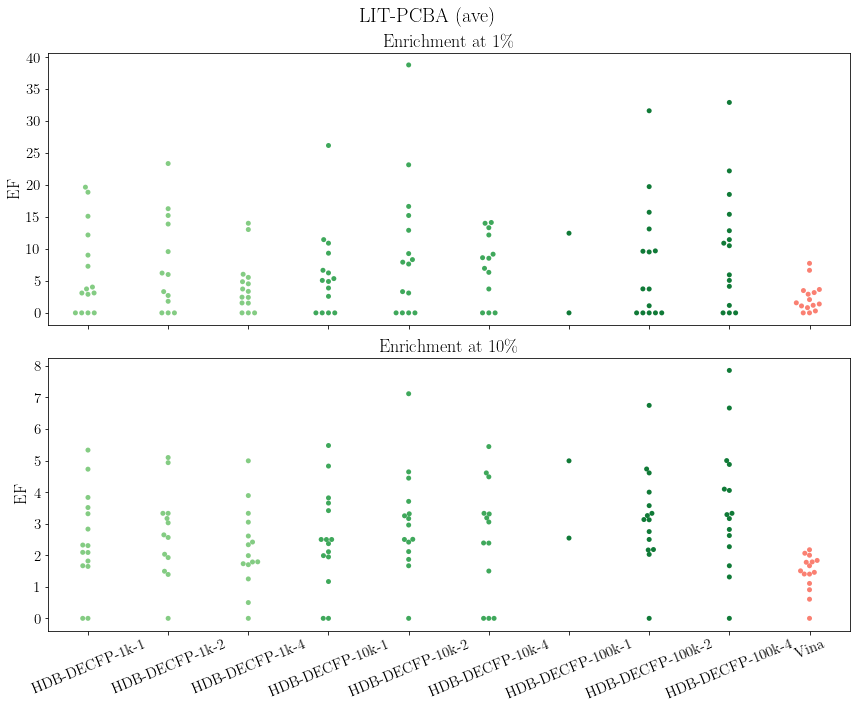

In [17]:
ave_df = compute_model_metric_df(dataset="lit-pcba", split="ave", target_list="all")

In [18]:
ave_df.describe()

,enrich,p,seed
count,2282.000000,2282.00000,2252.000000
mean,5.207346,0.05500,4.476021
std,6.405636,0.04501,2.883932
min,0.000000,0.01000,0.000000
25%,1.585747,0.01000,2.000000
50%,3.328244,0.05500,4.000000
75%,5.874332,0.10000,7.000000
max,41.277430,0.10000,9.000000


In [19]:
ave_df.groupby(["model", "p"]).median()

enrich  seed
model                    p                    
Vina                     0.01   1.572884   NaN
                         0.10   1.505012   NaN
hdbind-directecfp-100k-1 0.01   0.000000   4.5
                         0.10   4.086104   4.5
hdbind-directecfp-100k-2 0.01   4.150100   4.5
                         0.10   3.328244   4.5
hdbind-directecfp-100k-4 0.01  10.049347   4.5
                         0.10   3.328244   4.5
hdbind-directecfp-10k-1  0.01   5.874332   4.0
                         0.10   2.683649   4.0
hdbind-directecfp-10k-2  0.01   7.898564   4.5
                         0.10   2.965505   4.5
hdbind-directecfp-10k-4  0.01   6.860255   4.5
                         0.10   3.023665   4.5
hdbind-directecfp-1k-1   0.01   4.150100   4.5
                         0.10   2.226657   4.5
hdbind-directecfp-1k-2   0.01   4.242424   4.5
                         0.10   2.708178   4.5
hdbind-directecfp-1k-4   0.01   3.671457   4.5
                         0.10   2.083214   4.5

In [20]:
random_df = compute_model_metric_df(dataset="lit-pcba", split="random", target_list="all")

492947 ADRB2
train_actives.shape (13, 3) train_inactives.shape (234363, 3) test_actives.shape (4, 3) test_inactives.shape (78120, 3)
dock_actives.shape (128, 23) dock_inactives.shape (2499856, 23)
train_df.shape (234376, 4) test_df.shape (78124, 4)
dock_actives.shape (128, 24) dock_inactives.shape (2499856, 24)
active_lig_map_df.shape (16, 7) inactive_lig_map_df.shape (312482, 7)
active_df.shape (128, 31) inactive_df.shape (2499856, 31)
train_active_df.shape (96, 35) train_inactive_df.shape (1874896, 35)
test_active_df.shape (32, 35) test_inactive_df.shape (624960, 35)
train_data size  (1874992, 35) (234374,)
test_data size (624992, 35) (78124,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1030 ALDH1
train_actives.shape (4032, 3) train_inactives.shape (77606, 3) test_actives.shape (1344, 3) test_inactives.shape (25868, 3)
dock_actives.shape (57336, 23) dock_inactives.shape (1103712, 23)
train_df.shape (81638, 4) test_df.shape (27212, 4)
dock_actives.shape (57336, 24) dock_inactives.shape (1103712, 24)
active_lig_map_df.shape (7167, 7) inactive_lig_map_df.shape (137964, 7)
active_df.shape (57336, 31) inactive_df.shape (1103712, 31)
train_active_df.shape (32256, 35) train_inactive_df.shape (620840, 35)
test_active_df.shape (10744, 35) test_inactive_df.shape (206944, 35)
train_data size  (653096, 35) (81637,)
test_data size (217688, 35) (27211,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



743075 ESR1_ago
train_actives.shape (10, 3) train_inactives.shape (4188, 3) test_actives.shape (3, 3) test_inactives.shape (1395, 3)
dock_actives.shape (180, 23) dock_inactives.shape (83730, 23)
train_df.shape (4198, 4) test_df.shape (1398, 4)
dock_actives.shape (180, 24) dock_inactives.shape (83730, 24)
active_lig_map_df.shape (12, 7) inactive_lig_map_df.shape (5582, 7)
active_df.shape (180, 31) inactive_df.shape (83730, 31)
train_active_df.shape (135, 35) train_inactive_df.shape (62805, 35)
test_active_df.shape (45, 35) test_inactive_df.shape (20925, 35)
train_data size  (62940, 35) (4196,)
test_data size (20970, 35) (1398,)

743080 ESR1_ant
train_actives.shape (77, 3) train_inactives.shape (3711, 3) test_actives.shape (25, 3) test_inactives.shape (1237, 3)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


dock_actives.shape (1515, 23) dock_inactives.shape (74205, 23)
train_df.shape (3788, 4) test_df.shape (1262, 4)
dock_actives.shape (1515, 24) dock_inactives.shape (74205, 24)
active_lig_map_df.shape (101, 7) inactive_lig_map_df.shape (4947, 7)
active_df.shape (1515, 31) inactive_df.shape (74205, 31)
train_active_df.shape (1140, 35) train_inactive_df.shape (55665, 35)
test_active_df.shape (375, 35) test_inactive_df.shape (18540, 35)
train_data size  (56805, 35) (3787,)
test_data size (18915, 35) (1261,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



588795 FEN1
train_actives.shape (277, 3) train_inactives.shape (266552, 3) test_actives.shape (92, 3) test_inactives.shape (88850, 3)
dock_actives.shape (368, 23) dock_inactives.shape (355401, 23)
train_df.shape (266829, 4) test_df.shape (88942, 4)
dock_actives.shape (368, 24) dock_inactives.shape (355401, 24)
active_lig_map_df.shape (368, 7) inactive_lig_map_df.shape (355401, 7)
active_df.shape (368, 31) inactive_df.shape (355401, 31)
train_active_df.shape (276, 35) train_inactive_df.shape (266551, 35)
test_active_df.shape (92, 35) test_inactive_df.shape (88850, 35)
train_data size  (266827, 35) (266827,)
test_data size (88942, 35) (88942,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



2101 GBA
train_actives.shape (125, 3) train_inactives.shape (222039, 3) test_actives.shape (41, 3) test_inactives.shape (74013, 3)
dock_actives.shape (990, 23) dock_inactives.shape (1776306, 23)
train_df.shape (222164, 4) test_df.shape (74054, 4)
dock_actives.shape (990, 24) dock_inactives.shape (1776306, 24)
active_lig_map_df.shape (165, 7) inactive_lig_map_df.shape (296051, 7)
active_df.shape (990, 31) inactive_df.shape (1776306, 31)
train_active_df.shape (744, 35) train_inactive_df.shape (1332228, 35)
test_active_df.shape (246, 35) test_inactive_df.shape (444078, 35)
train_data size  (1332972, 35) (222162,)
test_data size (444324, 35) (74054,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



602179 IDH1
train_actives.shape (30, 3) train_inactives.shape (271537, 3) test_actives.shape (9, 3) test_inactives.shape (90512, 3)
dock_actives.shape (532, 23) dock_inactives.shape (5068672, 23)
train_df.shape (271567, 4) test_df.shape (90521, 4)
dock_actives.shape (532, 24) dock_inactives.shape (5068672, 24)
active_lig_map_df.shape (38, 7) inactive_lig_map_df.shape (362048, 7)
active_df.shape (532, 31) inactive_df.shape (5068672, 31)
train_active_df.shape (406, 35) train_inactive_df.shape (3801504, 35)
test_active_df.shape (126, 35) test_inactive_df.shape (1267168, 35)
train_data size  (3801910, 35) (271565,)
test_data size (1267294, 35) (90521,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



504327 KAT2A
train_actives.shape (146, 3) train_inactives.shape (261411, 3) test_actives.shape (48, 3) test_inactives.shape (87137, 3)
dock_actives.shape (579, 23) dock_inactives.shape (1045641, 23)
train_df.shape (261557, 4) test_df.shape (87185, 4)
dock_actives.shape (579, 24) dock_inactives.shape (1045641, 24)
active_lig_map_df.shape (193, 7) inactive_lig_map_df.shape (348547, 7)
active_df.shape (579, 31) inactive_df.shape (1045641, 31)
train_active_df.shape (435, 35) train_inactive_df.shape (784230, 35)
test_active_df.shape (144, 35) test_inactive_df.shape (261411, 35)
train_data size  (784665, 35) (261555,)
test_data size (261555, 35) (87185,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



995 MAPK1
train_actives.shape (231, 3) train_inactives.shape (46972, 3) test_actives.shape (77, 3) test_inactives.shape (15657, 3)
dock_actives.shape (4605, 23) dock_inactives.shape (939420, 23)
train_df.shape (47203, 4) test_df.shape (15734, 4)
dock_actives.shape (4605, 24) dock_inactives.shape (939420, 24)
active_lig_map_df.shape (307, 7) inactive_lig_map_df.shape (62628, 7)
active_df.shape (4605, 31) inactive_df.shape (939420, 31)
train_active_df.shape (3450, 35) train_inactive_df.shape (704565, 35)
test_active_df.shape (1155, 35) test_inactive_df.shape (234855, 35)
train_data size  (708015, 35) (47201,)
test_data size (236010, 35) (15734,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



493208 MTORC1
train_actives.shape (73, 3) train_inactives.shape (24729, 3) test_actives.shape (24, 3) test_inactives.shape (8243, 3)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:24: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  dock_inactives = pd.read_csv(f"/p/vast1/jones289/LIT-PCBA-Data/{target_name}-inactives.csv")


dock_actives.shape (1056, 23) dock_inactives.shape (362681, 23)
train_df.shape (24802, 4) test_df.shape (8267, 4)
dock_actives.shape (1056, 24) dock_inactives.shape (362681, 24)
active_lig_map_df.shape (96, 7) inactive_lig_map_df.shape (32971, 7)
active_df.shape (1056, 31) inactive_df.shape (362681, 31)
train_active_df.shape (803, 35) train_inactive_df.shape (272019, 35)
test_active_df.shape (253, 35) test_inactive_df.shape (90662, 35)
train_data size  (272822, 35) (24802,)
test_data size (90915, 35) (8265,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1777 OPRK1
train_actives.shape (18, 3) train_inactives.shape (202362, 3) test_actives.shape (6, 3) test_inactives.shape (67454, 3)
dock_actives.shape (23, 23) dock_inactives.shape (269815, 23)
train_df.shape (202380, 4) test_df.shape (67460, 4)
dock_actives.shape (23, 24) dock_inactives.shape (269815, 24)
active_lig_map_df.shape (23, 7) inactive_lig_map_df.shape (269815, 7)
active_df.shape (23, 31) inactive_df.shape (269815, 31)
train_active_df.shape (17, 35) train_inactive_df.shape (202361, 35)
test_active_df.shape (6, 35) test_inactive_df.shape (67454, 35)
train_data size  (202378, 35) (202378,)
test_data size (67460, 35) (67460,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



1631 PKM2
train_actives.shape (410, 3) train_inactives.shape (184143, 3) test_actives.shape (136, 3) test_inactives.shape (61380, 3)
dock_actives.shape (4905, 23) dock_inactives.shape (2209698, 23)
train_df.shape (184553, 4) test_df.shape (61516, 4)
dock_actives.shape (4905, 24) dock_inactives.shape (2209698, 24)
active_lig_map_df.shape (545, 7) inactive_lig_map_df.shape (245522, 7)
active_df.shape (4905, 31) inactive_df.shape (2209698, 31)
train_active_df.shape (3681, 35) train_inactive_df.shape (1657278, 35)
test_active_df.shape (1224, 35) test_inactive_df.shape (552420, 35)
train_data size  (1660959, 35) (184551,)
test_data size (553644, 35) (61516,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)



743094 PPARG
train_actives.shape (21, 3) train_inactives.shape (3909, 3) test_actives.shape (6, 3) test_inactives.shape (1302, 3)
dock_actives.shape (390, 23) dock_inactives.shape (78150, 23)
train_df.shape (3930, 4) test_df.shape (1308, 4)
dock_actives.shape (390, 24) dock_inactives.shape (78150, 24)
active_lig_map_df.shape (26, 7) inactive_lig_map_df.shape (5210, 7)
active_df.shape (390, 31) inactive_df.shape (78150, 31)
train_active_df.shape (300, 35) train_inactive_df.shape (58620, 35)
test_active_df.shape (90, 35) test_inactive_df.shape (19530, 35)
train_data size  (58920, 35) (3928,)
test_data size (19620, 35) (1308,)

651631 TP53
train_actives.shape (60, 3) train_inactives.shape (3126, 3) test_actives.shape (19, 3) test_inactives.shape (1042, 3)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


dock_actives.shape (468, 23) dock_inactives.shape (25002, 23)
train_df.shape (3186, 4) test_df.shape (1061, 4)
dock_actives.shape (468, 24) dock_inactives.shape (25002, 24)
active_lig_map_df.shape (78, 7) inactive_lig_map_df.shape (4167, 7)
active_df.shape (468, 31) inactive_df.shape (25002, 31)
train_active_df.shape (354, 35) train_inactive_df.shape (18750, 35)
test_active_df.shape (114, 35) test_inactive_df.shape (6252, 35)
train_data size  (19104, 35) (3184,)
test_data size (6366, 35) (1061,)

504847 VDR


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


train_actives.shape (498, 3) train_inactives.shape (199906, 3) test_actives.shape (165, 3) test_inactives.shape (66635, 3)
dock_actives.shape (1766, 23) dock_inactives.shape (710774, 23)
train_df.shape (200404, 4) test_df.shape (66800, 4)
dock_actives.shape (1766, 24) dock_inactives.shape (710774, 24)
active_lig_map_df.shape (883, 7) inactive_lig_map_df.shape (355387, 7)
active_df.shape (1766, 31) inactive_df.shape (710774, 31)
train_active_df.shape (996, 35) train_inactive_df.shape (399810, 35)
test_active_df.shape (330, 35) test_inactive_df.shape (133270, 35)
train_data size  (400806, 35) (200403,)
test_data size (133600, 35) (66800,)


/var/tmp/jones289/ipykernel_3417973/2005715264.py:82: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_df["min_vina"] = test_df[test_df.columns[11:21]].min(axis=1)


0it [00:00, ?it/s]/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-ADRB2-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-ALDH1-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-ESR1_ago-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)


y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-ESR1_ant-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-FEN1-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: 

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-GBA-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055,

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-IDH1-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (9052

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-KAT2A-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-MAPK1-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15

MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-MTORC1-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-OPRK1-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-PKM2-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (6151

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-PPARG-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)


y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-TP53-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)


y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-2.lit-pcba-VDR-random.1000.pkl hdbind-directecfp-10k-2
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true

 50%|█████     | 5/10 [03:44<03:44, 44.86s/it]

ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-ADRB2-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-ALDH1-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-ESR1_ago-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)


y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-ESR1_ant-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-FEN1-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: 

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-GBA-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055,

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-IDH1-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (9052

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-KAT2A-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-MAPK1-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15

MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-MTORC1-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-OPRK1-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-PKM2-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (6151

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-PPARG-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-TP53-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_p

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-10k-4.lit-pcba-VDR-random.1000.pkl hdbind-directecfp-10k-4
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score:

 60%|██████    | 6/10 [07:07<05:19, 79.99s/it]

ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-ADRB2-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-ALDH1-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-ESR1_ago-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)


y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-ESR1_ant-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (12

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-FEN1-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-GBA-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (7405

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-IDH1-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-KAT2A-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-MAPK1-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (

MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-MTORC1-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-OPRK1-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460,

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-PKM2-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61

PPARG /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-PPARG-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-TP53-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)


y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-1.lit-pcba-VDR-random.1000.pkl hdbind-directecfp-100k-1
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y

 70%|███████   | 7/10 [10:36<05:33, 111.18s/it]

ADRB2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-ADRB2-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (

ALDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-ALDH1-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (

ESR1_ago /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-ESR1_ago-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (13

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-ESR1_ant-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (12

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-FEN1-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943

GBA /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-GBA-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (7405

IDH1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-IDH1-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90

KAT2A /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-KAT2A-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (

MAPK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-MAPK1-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (

MTORC1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-MTORC1-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-OPRK1-random.1000.pkl hdbind-directecfp-100k-2
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (674

PKM2 /p/vast1/jones289/hd_results/1000/hdbind-directecfp-100k-2.lit-pcba-PKM2-random.1000.pkl hdbind-directecfp-100k-2


 70%|███████   | 7/10 [13:22<05:43, 114.60s/it]


RuntimeError: PytorchStreamReader failed reading file version: invalid header or archive is corrupted

In [ ]:
random_df.describe()